In [41]:
#importing libraries
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split
from wordcloud import WordCloud,STOPWORDS
from html.parser import HTMLParser
import re
import nltk
from nltk.corpus import stopwords

In [42]:
Answers = pd.read_excel('/Users/hardeepsingh/Desktop/IS/Sem-2/660/project/Final/Stack_Overflow_Full_Answers.xlsx')

In [43]:
#Selecting unique users and retheir reputation score
User_id_inA= Answers['User'].unique()
All_User_id_inA= Answers['User']
Rep_score=Answers['Reputation Score']

In [52]:
Answers.head()

,Question Id,Answer,User,Reputation Score,Gold Badge Count,Silver Badge Count,Bronze Badge Count,Cluster,Frequency
0,49369729,I've used ReadTheDocs for many of my own proje...,Pal Kerecsenyi,28.0,NaN,NaN,6.0,2.0,1
1,49369729,For API docs you can use swagger or apidoc.,bharath,318.0,NaN,1.0,1.0,2.0,1
2,49369657,A purrr option:,alistaire,27000.0,4.0,4.0,4.0,1.0,2
3,49369657,Working example:,Ramon Diogo,218.0,NaN,3.0,3.0,1.0,1
4,49369594,Given your datastructure and a list of values ...,Ajax1234,27200.0,4.0,4.0,4.0,8.0,7


In [45]:
users=pd.DataFrame({'idUser':list(All_User_id_inA)})
Answers['Frequency']=users['idUser'].apply(lambda x:len(Answers[Answers['User']==x]['Answer']))

In [46]:
#Striping and cleaning answers that will help to get better evaluation.
class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

def clean(text):
    removed_html=strip_tags(text)
    letters_only = re.sub("[^a-zA-Z]", " ", removed_html) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return(meaningful_words)

A_data=Answers[['User','Answer','Reputation Score']]
Answer=A_data[A_data['User'].isin(User_id_inA)]

Answer['Non_html_body']=Answer['Answer'].apply(lambda x:strip_tags(str(x)))



In [47]:
#data frame with each row containing all answers the user
Answer['A_words']=Answer['Answer'].apply(lambda x:clean(str(x)))

#DataFrame containing answers
User_id=User_id_inA
Answer_corpus=[]
for id in User_id_inA:
    A_frame=Answer[Answer['User']==id].reset_index(drop=True)
    
    for j in range(len(A_frame['User'])):
        if j==0:
            tmp2=A_frame['A_words'][j]
        else:
            tmp2=tmp2+A_frame['A_words'][j]
    Answer_corpus.append(tmp2)

Answer_C=[]
for i in range(len(User_id)):
    tmp2=" ".join(Answer_corpus[i])
    Answer_C.append(tmp2)

Final_frame=pd.DataFrame({'User_id':User_id,'Answer':Answer_C,})

In [48]:
#tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer()
A_features=tfidf.fit_transform(Answer_C)

In [49]:
#KNN
from sklearn.neighbors import NearestNeighbors
knn=NearestNeighbors(n_neighbors=30,algorithm='brute',metric='cosine')
Answer_fit=knn.fit(A_features)

------------------------------------------------------------------------------------------------------
User's answer is always featured by words below


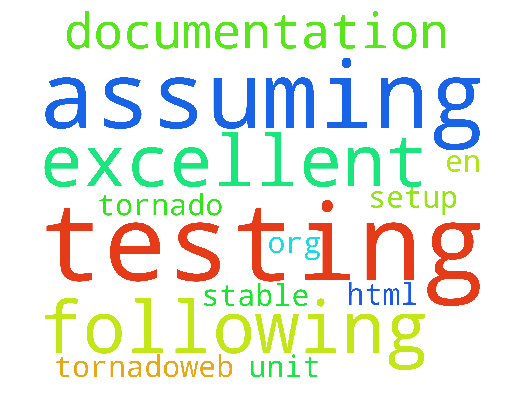

------------------------------------------------------------------------------------------------------
The top five users that always provide similar answers are: Steve Benedict K. EB88 sancho.s Einstein
------------------------------------------------------------------------------------------------------
Example: Answer from user:
Assuming the following:
------------------------------------------------------------------------------------------------------
Example: Answer from a similar user:
This is the library you're looking for:
https://docs.python.org/2/howto/curses.html
------------------------------------------------------------------------------------------------------
User's answer is always featured by words below


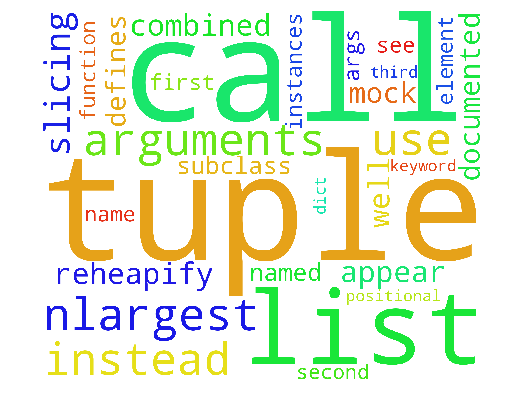

------------------------------------------------------------------------------------------------------
The top five users that always provide similar answers are: Pop pgngp Joe Lazaro litepresence nasil122002
------------------------------------------------------------------------------------------------------
Example: Answer from user:
Use nlargest instead of slicing, then reheapify the combined lists.
------------------------------------------------------------------------------------------------------
Example: Answer from a similar user:
The idea is that state is a tuple.


In [50]:
#users share similar expertise. 
#This will to understand User's answer is always featured by what words, 
#users that always provide similar answers, example of answer posted by user and answers from a similar user.

def Answer_f(user_id):
    ###Find the corresponding features##
    index=Final_frame[Final_frame['User_id']==user_id].index.tolist()
    ### Word Cloud##
    Answer_word=Answer_C[index[0]]
    wordcloud = WordCloud(background_color='white',
                      width=3000,
                      height=2500
                     ).generate(Answer_word)
    Neighbors = Answer_fit.kneighbors(A_features[index[0]])[1].tolist()[0][1:]
    Users=np.array(User_id)[Neighbors].tolist()
    print('------------------------------------------------------------------------------------------------------')
    print("User's answer is always featured by words below")
    plt.figure(1,figsize=(8,8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    print('------------------------------------------------------------------------------------------------------')
    print('The top five users that always provide similar answers are: '+str(Users[0])+' '+str(Users[1])+' '+str(Users[2])+' '+str(Users[3])+' '+str(Users[4]))
    print('------------------------------------------------------------------------------------------------------')
    User_answer=Answer[Answer['User']==user_id].reset_index(drop=True)['Non_html_body'][0]
    print('Example: Answer from user:\n'+User_answer)
    print('------------------------------------------------------------------------------------------------------')
    Answer2=Answer[Answer['User']==Users[0]].reset_index(drop=True)['Non_html_body'][0]
    print('Example: Answer from a similar user:\n'+Answer2)

#passing username to check users share similar expertise
Answer_f('Michael Robellard')
Answer_f('chepner')

In [61]:
#Displaying top 10 unique users in each cluster based on their number of answers 
#also based on their reputation score
out = Answers.groupby('Cluster')
out.describe()
df = pd.DataFrame()
op = pd.DataFrame()
count = 0
while count < 2:#value can be changed to 10 to display top 5 values in all clusters
    df = Answers.loc[Answers['Cluster'] == count]
    print('Values for cluster:', count)
    op = df['User'].unique()
    usersx=pd.DataFrame({'idUser':list(op)})
    df['Frequency']=usersx['idUser'].apply(lambda x:len(df[df['User']==x]['Answer']))
    #Selecting top 5 Frequency in cluster
    print("Users with highest number of answers \n",df.nlargest(5, 'Frequency'))
    print('------------------------------------------------------------------------------------------------------')
    print("\n")

    #Selecting Top 5 Repustion score in cluster
    print("Users with highest Reputation Score \n",df.nlargest(5,'Reputation Score'))
    print('------------------------------------------------------------------------------------------------------')
    print("\n")
    print("\n")
    print("\n")
    print("\n")
    count=count+1


Values for cluster: 0
Users with highest number of answers 
     Question Id                                             Answer  \
47     49367296  Use DataFrame.duplicated() to check if your da...   
85     49364969                    roll accepts an axis parameter:   
19     49368882  You either have to set the inplace parameter o...   
23     49368475  df_new is a transformation from my_big_hdfs_df...   
41     49367586  So, when you read excel your first row will be...   

               User  Reputation Score  Gold Badge Count  Silver Badge Count  \
47           Doodle             114.0               NaN                 NaN   
85        cᴏʟᴅsᴘᴇᴇᴅ           82000.0              13.0                13.0   
19            Surya              31.0               NaN                 NaN   
23  Ramesh Maharjan           17700.0               2.0                 2.0   
41             zipa           10100.0               2.0                 2.0   

    Bronze Badge Count  Cluster  Frequency 

/Users/hardeepsingh/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
